In [1]:
import tensorflow as tf
import tensorflow_text as tftext
import numpy as np

import typing
from typing import Any, Tuple


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

2022-07-05 12:36:41.925310: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-05 12:36:41.925426: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
use_builtins = True

##### Shape Checker

In [3]:
# Shape Chekcer

class ShapeChecker():
    def __init__(self):
        self.shapes = dict()

    def __call__(self, tensor, names, broadcast=False):
        if not tf.executing_eagerly():
            return
        
        if isinstance(names, str):
            names = (names,)
        
        shape = tf.shape(tensor)
        rank = tf.rank(tensor)
        
        if rank != len(names):
            raise ValueError(f"Rank mismatch:\n"
                             f"     found {rank}: {shape.numpy()}\n"
                             f"     expected {len(names)}: {names}"
                             )
        
        for i, name in enumerate(names):
            if isinstance(name, int):
                old_dim = name
            else:
                old_dim = self.shapes.get(name, None)
            new_dim = shape[i]

            if (broadcast and new_dim == 1):
                continue

            if old_dim is None:
                # If the axis name is new, add its length to the cache.
                self.shapes[name] = new_dim
                continue
            
            if new_dim != old_dim:
                raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                                 f"     found: {new_dim}\n"
                                 f"     expected: {old_dim}\n"
                                 )


In [4]:
import pathlib

path_to_zip = tf.keras.utils.get_file(
    cache_subdir=pathlib.Path.cwd(),
    cache_dir=pathlib.Path.cwd(),
    origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
    extract=True
)


path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

In [5]:
def load_data(path):
    text = path.read_text(encoding='utf-8')

    lines = text.splitlines()
    pairs = [line.split('\t') for line in lines]

    inp = [inp for target, inp in pairs]
    target = [target for target, input in pairs]

    return target, inp

In [6]:
target, inp = load_data(path_to_file)
print(inp[-1], '\n', target[-1], sep='')

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.
If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


In [7]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

dataset =  tf.data.Dataset.from_tensor_slices((inp, target)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

2022-07-05 12:37:21.685368: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-05 12:37:21.685470: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-05 12:37:21.685978: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-KRMLHC6): /proc/driver/nvidia/version does not exist
2022-07-05 12:37:21.689385: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [9]:
for example_input_batch, example_target_batch in dataset.take(1):
    print(example_input_batch[:5], '\n')
    print(example_target_batch[:5])
    

tf.Tensor(
[b'Dicen que Venecia es una hermosa ciudad.'
 b'\xc3\x89l no est\xc3\xa1 seguro de querer hacerlo.'
 b'Todav\xc3\xada no se ha le\xc3\xaddo el libro.'
 b'\xc2\xbfAlguien est\xc3\xa1 herido?'
 b'Aprender una lengua extranjera requiere mucho tiempo.'], shape=(5,), dtype=string) 

tf.Tensor(
[b'They say that Venice is a beautiful city.'
 b"He's not sure he wants to do this." b"He hasn't read the book yet."
 b'Anyone hurt?' b'To learn a foreign language requires a lot of time.'], shape=(5,), dtype=string)


### Text Preprocessing

##### Unicode Normalization

In [10]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text)
print(tftext.normalize_utf8(example_text, 'NFKD'))

tf.Tensor(b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?', shape=(), dtype=string)
tf.Tensor(b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?', shape=(), dtype=string)


In [11]:
def tf_lower_and_split_punct(text):
    # Split accented characters
    text = tftext.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)

    # Keep space char, a to z and certain punctuations
    # Replace with blank everything except this regex
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    # Add spaces around punctuation
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    # Strip extra whitespace
    text = tf.strings.strip(text)

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

In [12]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


##### Text Vectorization

In [13]:
max_vocab_size = 5000

input_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size
)

In [14]:
input_text_processor.adapt(inp) # inp is the list of all spanish examples

# FIrst 10 words from the vocab:
input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

In [15]:
input_text_processor.get_vocabulary()[:50]

['',
 '[UNK]',
 '[START]',
 '[END]',
 '.',
 'que',
 'de',
 'el',
 'a',
 'no',
 'tom',
 'la',
 '?',
 '¿',
 'en',
 'es',
 'un',
 'se',
 'me',
 ',',
 'esta',
 'por',
 'lo',
 'una',
 'mi',
 'su',
 'los',
 'con',
 'le',
 'ella',
 'te',
 'para',
 'mary',
 'y',
 'las',
 'mas',
 'tu',
 'al',
 'como',
 'yo',
 'este',
 'estoy',
 'muy',
 'eso',
 'tiene',
 'si',
 'del',
 'estaba',
 'quiero',
 'tengo']

In [16]:
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size
)

output_text_processor.adapt(target)
output_text_processor.get_vocabulary()[:20]

['',
 '[UNK]',
 '[START]',
 '[END]',
 '.',
 'the',
 'i',
 'to',
 'you',
 'tom',
 'a',
 '?',
 'is',
 'he',
 'in',
 'of',
 'that',
 'it',
 'was',
 ',']

In [17]:
print(example_input_batch)
example_tokens = input_text_processor(example_input_batch)
# the number of example sentences and the length of each sentence
# extra lengths are padded with 0s
example_tokens[:4, :]

tf.Tensor(
[b'Dicen que Venecia es una hermosa ciudad.'
 b'\xc3\x89l no est\xc3\xa1 seguro de querer hacerlo.'
 b'Todav\xc3\xada no se ha le\xc3\xaddo el libro.'
 b'\xc2\xbfAlguien est\xc3\xa1 herido?'
 b'Aprender una lengua extranjera requiere mucho tiempo.'
 b'Tom ech\xc3\xb3 a Mar\xc3\xada del bar.'
 b'El ni\xc3\xb1o corri\xc3\xb3 hacia su madre.'
 b'El a\xc3\xb1o pasado ocurrieron muchos accidentes automovil\xc3\xadsticos.'
 b'El problema es que \xc3\xa9l no tiene dinero.' b'Tom gan\xc3\xb3.'
 b'Tom\xc3\xa1s hoy se ve much\xc3\xadsimo mejor.'
 b'Compr\xc3\xa9 la misma c\xc3\xa1mara que tienes t\xc3\xba.'
 b'No s\xc3\xa9 cu\xc3\xa1ndo volvi\xc3\xb3 de Francia.'
 b'Uno de nosotros deber\xc3\xada hablar con Tom.'
 b'Tom escuch\xc3\xb3 un helic\xc3\xb3ptero por encima de su cabeza.'
 b'Es dif\xc3\xadcil para un anciano cambiar su manera de pensar.'
 b'Le haremos hablar, cueste lo que cueste.'
 b'\xc2\xbfQuer\xc3\xa9is sentaros?' b'El mundo es un pa\xc3\xb1uelo.'
 b'Tom nunca hizo eso a

<tf.Tensor: shape=(4, 20), dtype=int64, numpy=
array([[   2,  869,    5,    1,   15,   23,  779,  222,    4,    3,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,    7,    9,   20,  206,    6, 1982,  198,    4,    3,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,  147,    9,   17,   61,  927,    7,  105,    4,    3,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,   13,  155,   20, 1093,   12,    3,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0]])>

In [18]:
# convert from tokens back to IDs
input_vocab = np.array(input_text_processor.get_vocabulary())
print(example_tokens[0])
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

tf.Tensor(
[  2 869   5   1  15  23 779 222   4   3   0   0   0   0   0   0   0   0
   0   0], shape=(20,), dtype=int64)


'[START] dicen que [UNK] es una hermosa ciudad . [END]          '

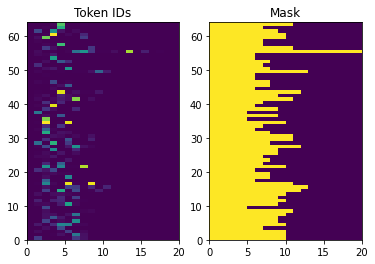

In [19]:
# Visualizing a map and  a mask.
# y axis represents the different strings,
# x axis represents the word in the strings
# the activation of a cell represents the magnitude of the token

plt.subplot(1,2,1)
plt.pcolormesh(example_tokens)
plt.title("Token IDs")

plt.subplot(1,2,2)
plt.pcolormesh(example_tokens!=0)
plt.title("Mask")

plt.show()

### The encoder/decoder model

#### Encoder

In [20]:
# Model constants

embedding_dim = 256
units = 1024

In [21]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.input_vocab_size = input_vocab_size

        # The embedding layer converts tokens to vectors
        self.embedding1 = tf.keras.layers.Embedding(
            self.input_vocab_size,
            embedding_dim
        )

        # The GRU layer proceses these embedding vectors as sequences
        self.gru1 = tf.keras.layers.GRU(
            self.enc_units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer='glorot_uniform'
        )

    def call(self, tokens, state=None):
        shape_checker = ShapeChecker()
        shape_checker(tokens, ('batch', 's'))

        vectors = self.embedding1(tokens)
        shape_checker(vectors, ('batch', 's', 'embed_dim'))

        # The GRU processes the embedding sequence
        # Output Shape: (batch, s, enc_units)
        # State shape: (batch, enc_units)
        output, state = self.gru1(vectors, initial_state=state)
        shape_checker(output, ('batch', 's', 'enc_units'))
        shape_checker(state, ('batch', 'enc_units'))

        return output, state

In [22]:
example_tokens = input_text_processor(example_input_batch)

# Initialize the encoder
encoder = Encoder(
    input_text_processor.vocabulary_size(),
    embedding_dim,
    units
)

# Get encoder output and state by passing the example through the encoder
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens shape (batch, s): {example_tokens.shape}')
print(f'Encoder output shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state shape (batch, units): {example_enc_state.shape}')

Input batch shape (batch): (64,)
Input batch tokens shape (batch, s): (64, 20)
Encoder output shape (batch, s, units): (64, 20, 1024)
Encoder state shape (batch, units): (64, 1024)


#### The attention head

In [23]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(units, use_bias=False)
        self.W2 = tf.keras.layers.Dense(units, use_bias=False)

        self.attention = tf.keras.layers.AdditiveAttention()

    def call(self, query, value, mask):
        shape_checker = ShapeChecker()
        shape_checker(query, ('batch', 't', 'query_units'))
        shape_checker(value, ('batch', 's', 'value_units'))
        shape_checker(mask, ('batch', 's'))

        w1_query = self.W1(query)
        shape_checker(w1_query, ('batch', 't', 'attention_units'))

        w2_key = self.W2(value)
        shape_checker(w2_key, ('batch', 's', 'attention_units'))

        query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
        value_mask = mask

        context_vector, attention_weights = self.attention(
            inputs=[w1_query, value, w2_key],
            mask=[query_mask, value_mask],
            return_attention_scores=True
        )

        shape_checker(context_vector, ('batch', 't', 'value_units'))
        shape_checker(attention_weights, ('batch', 't', 's'))

        return context_vector, attention_weights

In [24]:
attention_layer_test = BahdanauAttention(units)

In [25]:
(example_tokens != 0).shape

TensorShape([64, 20])

In [26]:
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

context_vector, attention_weights = attention_layer_test(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0)
)

print(f'Attention result shape: (batch_size, query_seq_length, units): {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units): (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 20)


Text(0.5, 1.0, 'Mask')

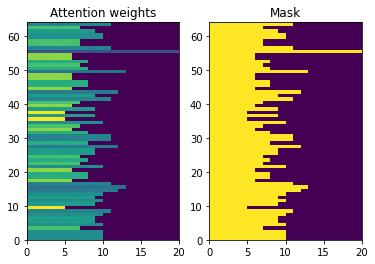

In [27]:
# THe attention weights should sum to 1 for each sequence
plt.subplot(1,2,1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title("Attention weights")

plt.subplot(1,2,2)
plt.pcolormesh(example_tokens!=0)
plt.title("Mask")

In [28]:
attention_weights.shape

TensorShape([64, 2, 20])

#### The decoder

In [29]:
class DecoderInput(typing.NamedTuple):
    new_tokens: Any
    enc_output: Any
    mask: Any

class DecoderOutput(typing.NamedTuple):
    logits: Any
    attention_weights: Any

In [30]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, output_vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.output_vocab_size = output_vocab_size
        self.embedding_dim = embedding_dim

        self.embedding1 = tf.keras.layers.Embedding(
            self.output_vocab_size,
            embedding_dim
        )

        self.gru1 = tf.keras.layers.GRU(
            self.dec_units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer='glorot_uniform'
        )

        self.attention1 = BahdanauAttention(self.dec_units)

        self.Wc = tf.keras.layers.Dense(
            dec_units,
            activation=tf.math.tanh,
            use_bias=False
        )

        self.fc = tf.keras.layers.Dense(self.output_vocab_size)

    def call(self,
            inputs: DecoderInput,
            state=None) -> Tuple[DecoderOutput, tf.Tensor]:
        shape_checker = ShapeChecker()
        shape_checker(inputs.new_tokens, ('batch', 't'))
        shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
        shape_checker(inputs.mask, ('batch', 's'))

        if state is not None:
            shape_checker(state, ('batch', 'dec_units'))

        # Lookup the embeddings
        vectors = self.embedding1(inputs.new_tokens)
        shape_checker(vectors, ('batch', 't', 'embedding_dim'))

        # Process one step with the RNN
        rnn_output, state = self.gru1(vectors, initial_state=state)

        shape_checker(rnn_output, ('batch', 't', 'dec_units'))
        shape_checker(state, ('batch', 'dec_units'))

        # Use the RNN output as the query for the attention over the encoder
        # output

        context_vector, attention_weights = self.attention1(
            query=rnn_output,
            value=inputs.enc_output,
            mask=inputs.mask
        )
        
        shape_checker(context_vector, ('batch', 't', 'dec_units'))
        shape_checker(attention_weights, ('batch', 't', 's'))
        
        # Join the context vector and rnn_output
        context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)
        
        attention_vector = self.Wc(context_and_rnn_output)
        shape_checker(attention_vector, ('batch', 't', 'dec_units'))

        logits = self.fc(attention_vector)
        shape_checker(logits, ('batch', 't', 'output_vocab_size'))

        return DecoderOutput(logits, attention_weights), state


In [31]:
decoder = Decoder(
    output_text_processor.vocabulary_size(),
    embedding_dim,
    units
)

The decoder takes 4 inputs.

* new_tokens - The last token generated. Initialize the decoder with the "[START]" token.
* enc_output - Generated by the Encoder.
* mask - A boolean tensor indicating where tokens != 0
* state - The previous state output from the decoder (the internal state of the decoder's RNN). Pass None to zero-initialize it. The original paper initializes it from the encoder's final RNN state

In [32]:
example_output_tokens = output_text_processor(example_target_batch)
start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])
first_token

<tf.Tensor: shape=(64, 1), dtype=int32, numpy=
array([[2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2]], dtype=int32)>

In [33]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs=DecoderInput(
        new_tokens=first_token,
        enc_output=example_enc_output,
        mask=(example_tokens!=0)
    ),
    state=example_enc_state
)

print(f"Logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}")
print(f"State shape: (batch_size, dec_units) {dec_state.shape}")

Logits shape: (batch_size, t, output_vocab_size) (64, 1, 5000)
State shape: (batch_size, dec_units) (64, 1024)


In [35]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
print(first_word.shape)
first_word[:5]

(64, 1)


array([['only'],
       ['glanced'],
       ['production'],
       ['national'],
       ['bar']], dtype='<U16')

In [36]:
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
    example_enc_output,
    mask=(example_tokens!=0)
    ),
    state=dec_state
)
sampled_token = tf.random.categorical(dec_result.logits[:,0,:], num_samples=1)
first_word =  vocab[sampled_token.numpy()]
first_word[:5]

array([['bottles'],
       ['facts'],
       ['crash'],
       ['impact'],
       ['operation']], dtype='<U16')

### Training

#### Loss

In [59]:
class MaskedLoss(tf.keras.losses.Loss):
    def __init__(self):
        self.name = 'masked_loss'
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True,
            reduction='none'
        )

    def __call__(self, y_true, y_pred):
        shape_checker = ShapeChecker()
        shape_checker(y_true, ('batch', 't'))
        shape_checker(y_pred, ('batch', 't', 'logits'))

        loss = self.loss(y_true, y_pred)
        shape_checker(loss, ('batch', 't'))

        # mask off the losses on padding - meaningless
        mask = tf.cast(y_true!=0, tf.float32)
        shape_checker(mask, ('batch', 't'))
        loss *= mask

        return tf.reduce_sum(loss)

#### Model for Train Step

In [68]:
class TrainTranslator(tf.keras.Model):
    def __init__(
                self,
                embedding_dim,
                units,
                input_text_processor,
                output_text_processor,
                use_tf_function=True
                ):
        super().__init__()

        encoder = Encoder(
            input_text_processor.vocabulary_size(),
            embedding_dim,
            units
        )
        decoder = Decoder(
            output_text_processor.vocabulary_size(),
            embedding_dim,
            units
        )

        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor
        self.use_tf_function = use_tf_function
        self.shape_checker = ShapeChecker()

    def train_step(self, inputs):
        self.shape_checker = ShapeChecker()
        if self.use_tf_function:
            return self._tf_train_step(inputs)
        else:
            return self._train_step(inputs)
    
    def _preprocess(self, input_text, target_text):
        self.shape_checker(input_text, ('batch',))
        self.shape_checker(target_text, ('batch', ))

        # Convert the text to token IDs
        input_tokens = self.input_text_processor(input_text)
        target_tokens = self.output_text_processor(target_text)
        self.shape_checker(input_tokens, ('batch', 's'))
        self.shape_checker(target_tokens, ('batch', 't'))

        input_mask = input_tokens!=0
        self.shape_checker(input_mask, ('batch', 's'))
        target_mask = target_tokens!=0
        self.shape_checker(target_mask, ('batch', 't'))

        return input_tokens, input_mask, target_tokens, target_mask
        
    def _train_step(self, inputs):
        input_text, target_text = inputs

        (input_tokens, input_mask,
        target_tokens, target_mask) = self._preprocess(input_text, target_text)

        max_target_length = tf.shape(target_tokens)[1]

        with tf.GradientTape() as tape:
            # Encode the input
            enc_output, enc_state = self.encoder(input_tokens)
            self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
            self.shape_checker(enc_state, ('batch', 'enc_units'))

            # init dec state to the encoder's final state
            # this only works if enc and dec have the same number of units
            dec_state = enc_state
            loss = tf.constant(0.0)

            for t in tf.range(max_target_length-1):
                # Pass the current input to the decoder and target for
                # the next prediction. These will be two tokens from the
                # target sequence
                new_tokens = target_tokens[:,t:t+2]
                step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                                        enc_output, dec_state)
                
                loss = loss + step_loss

            avg_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

        # Optimization step
        gradients = tape.gradient(avg_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return {'batch_loss': avg_loss}

    def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
        input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

        decoder_input = DecoderInput(
            new_tokens=input_token,
            enc_output=enc_output,
            mask=input_mask
        )

        dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
        self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
        self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
        self.shape_checker(dec_state, ('batch', 'dec_units'))

        y = target_token
        y_pred = dec_result.logits
        step_loss = self.loss(y, y_pred)

        return step_loss, dec_state
    
    @tf.function
    def _tf_train_step(self, inputs):
        return self._train_step(inputs)


In [69]:
translator = TrainTranslator(
    embedding_dim,
    units,
    input_text_processor,
    output_text_processor,
    use_tf_function=False
)

translator.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=MaskedLoss()
)

In [70]:
np.log(output_text_processor.vocabulary_size())

8.517193191416238

In [67]:
%%time
for n in range(10):
    print(translator.train_step([example_input_batch, example_target_batch]))
print("\n")

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.593755>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.562275>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.5036016>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.329206>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.632119>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.0783997>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.562949>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.408111>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.187345>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.014921>}


CPU times: user 5min 12s, sys: 31.8 s, total: 5min 44s
Wall time: 1min 23s


In [71]:
translator.use_tf_function = True

In [73]:
translator.train_step([example_input_batch, example_target_batch])

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.5937376>}

In [74]:
%%time
for n in range(10):
    print(translator.train_step([example_input_batch, example_target_batch]))
print("\n")

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.5622196>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.502313>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.321965>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.589846>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.836919>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.4230723>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.235688>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.053107>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9655254>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9608147>}


CPU times: user 3min 35s, sys: 12.8 s, total: 3min 48s
Wall time: 35.6 s


....................................................................................................



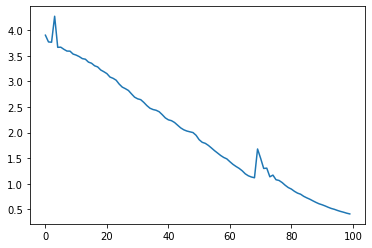

In [75]:
losses = []
for n in range(100):
    print(n+1, end='')
    logs = translator.train_step([example_input_batch, example_target_batch])
    losses.append(logs['batch_loss'].numpy())
print("\n")
plt.plot(losses)
plt.show()

In [76]:
losses[-1]

0.4094921